# ML 기반 베스트셀러 예측 분석 (v4)

## 데이터 설명

### 피처 구성 (43개)
| 그룹 | 피처 | 설명 |
|------|------|------|
| 카테고리 | category_1 ~ category_10 | 도서 카테고리 비율 |
| 카테고리×바이럴 | category_X_x_viral_index | 카테고리별 바이럴 영향 |
| Prophet 예측 | prophet_forecast_X | 카테고리별 판매 예측값 × 카테고리 비율 |
| 경제지표 | kospi, usd_krw, brent_oil 등 | 거시경제 변수 |

### Prophet 예측값 특징 (v4)
- 각 카테고리의 최적 시차(lag)가 적용된 예측값
- 해당 책의 카테고리 비율로 가중치 적용됨
- 예: 주식투자 60% 책 → prophet_forecast_stock × 0.6

---

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import (f1_score, roc_auc_score, r2_score, mean_absolute_error,
                             confusion_matrix, ConfusionMatrixDisplay, roc_curve)
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.svm import SVC
from scipy import stats
import lightgbm as lgb
import xgboost as xgb
import shap
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
warnings.filterwarnings('ignore')

plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['axes.unicode_minus'] = False

# 이미지 저장 경로
IMG_PATH = 'ml_image_v4'
os.makedirs(IMG_PATH, exist_ok=True)

## 1. 데이터 로드

In [2]:
df = pd.read_csv('books_ml_dataset_v4.csv')
df['ymw'] = df['ymw'].astype(str)
df = df.sort_values(['product_code', 'ymw']).reset_index(drop=True)

print(f'데이터: {len(df):,}개')
print(f'기간: {df["ymw"].min()} ~ {df["ymw"].max()}')
print(f'고유 책 수: {df["product_code"].nunique()}권')

데이터: 7,191개
기간: 2025012 ~ 2025124
고유 책 수: 141권


In [3]:
# 피처 정의
feature_cols = [c for c in df.columns if c not in ['product_code', 'ymw', 'y_sales_score']]

print(f'피처 수: {len(feature_cols)}개')
print(f'\n[피처 그룹별 개수]')
print(f'  category_: {len([c for c in feature_cols if c.startswith("category_") and "x_viral" not in c])}개')
print(f'  category_x_viral: {len([c for c in feature_cols if "x_viral" in c])}개')
print(f'  prophet_forecast_: {len([c for c in feature_cols if c.startswith("prophet_")])}개')
print(f'  기타 (경제지표 등): {len([c for c in feature_cols if not any(x in c for x in ["category", "prophet"])])}개')

피처 수: 43개

[피처 그룹별 개수]
  category_: 10개
  category_x_viral: 10개
  prophet_forecast_: 10개
  기타 (경제지표 등): 13개


## 2. Train/Test Split (Time-based)

In [4]:
# Time-based Split (시계열 데이터이므로 시간순 분할)
df_sorted = df.sort_values('ymw').reset_index(drop=True)
split_idx = int(len(df_sorted) * 0.8)

train_data = df_sorted.iloc[:split_idx]
test_data = df_sorted.iloc[split_idx:]

X_train = train_data[feature_cols]
X_test = test_data[feature_cols]
y_train = train_data['y_sales_score']
y_test = test_data['y_sales_score']
y_train_class = (y_train > 0).astype(int)
y_test_class = (y_test > 0).astype(int)

print('[Time-based Split]')
print(f'  Train: {train_data["ymw"].min()} ~ {train_data["ymw"].max()} ({len(train_data):,}개)')
print(f'  Test:  {test_data["ymw"].min()} ~ {test_data["ymw"].max()} ({len(test_data):,}개)')
print(f'\n[타겟 분포]')
print(f'  Train - 베스트셀러: {y_train_class.sum()} ({y_train_class.mean()*100:.1f}%)')
print(f'  Test  - 베스트셀러: {y_test_class.sum()} ({y_test_class.mean()*100:.1f}%)')

[Time-based Split]
  Train: 2025012 ~ 2025103 (5,752개)
  Test:  2025103 ~ 2025124 (1,439개)

[타겟 분포]
  Train - 베스트셀러: 1331 (23.1%)
  Test  - 베스트셀러: 283 (19.7%)


---
# Part 1: 기존 피처만 사용한 예측

바이럴 지수, Prophet 예측값, 카테고리 등 **외부 변수만으로** 베스트셀러를 예측할 수 있는가?

## 3. 기존 피처 상관관계 분석

In [5]:
# 타겟과 상관관계 분석
y_full = df['y_sales_score']
corr_list = []
for col in feature_cols:
    corr, pval = stats.pearsonr(df[col], y_full)
    corr_list.append({'feature': col, 'corr': corr, 'abs_corr': abs(corr), 'pval': pval})

corr_df = pd.DataFrame(corr_list).sort_values('abs_corr', ascending=False)

print('[기존 피처 vs 타겟 상관관계 Top 15]')
print('='*60)
print(f'{"순위":<5}{"피처":<40}{"r":<10}{"p-value":<12}')
print('-'*60)
for i, (_, row) in enumerate(corr_df.head(15).iterrows()):
    sig = '***' if row['pval'] < 0.001 else '**' if row['pval'] < 0.01 else '*' if row['pval'] < 0.05 else ''
    print(f'{i+1:<5}{row["feature"]:<40}{row["corr"]:+.4f}    {row["pval"]:.2e} {sig}')

[기존 피처 vs 타겟 상관관계 Top 15]
순위   피처                                      r         p-value     
------------------------------------------------------------
1    category_4                              -0.0949    7.25e-16 ***
2    category_10                             +0.0929    2.91e-15 ***
3    prophet_forecast_business               -0.0809    6.22e-12 ***
4    prophet_forecast_invest_philosophy      +0.0766    7.83e-11 ***
5    category_3                              +0.0624    1.16e-07 ***
6    category_5                              -0.0597    3.99e-07 ***
7    prophet_forecast_financial_crisis       +0.0475    5.60e-05 ***
8    prophet_forecast_econ_theory            +0.0435    2.26e-04 ***
9    prophet_forecast_tech_startup           -0.0403    6.32e-04 ***
10   category_9                              -0.0385    1.10e-03 **
11   category_2                              +0.0343    3.58e-03 **
12   prophet_forecast_personal_finance       +0.0338    4.09e-03 **
13   category_6     

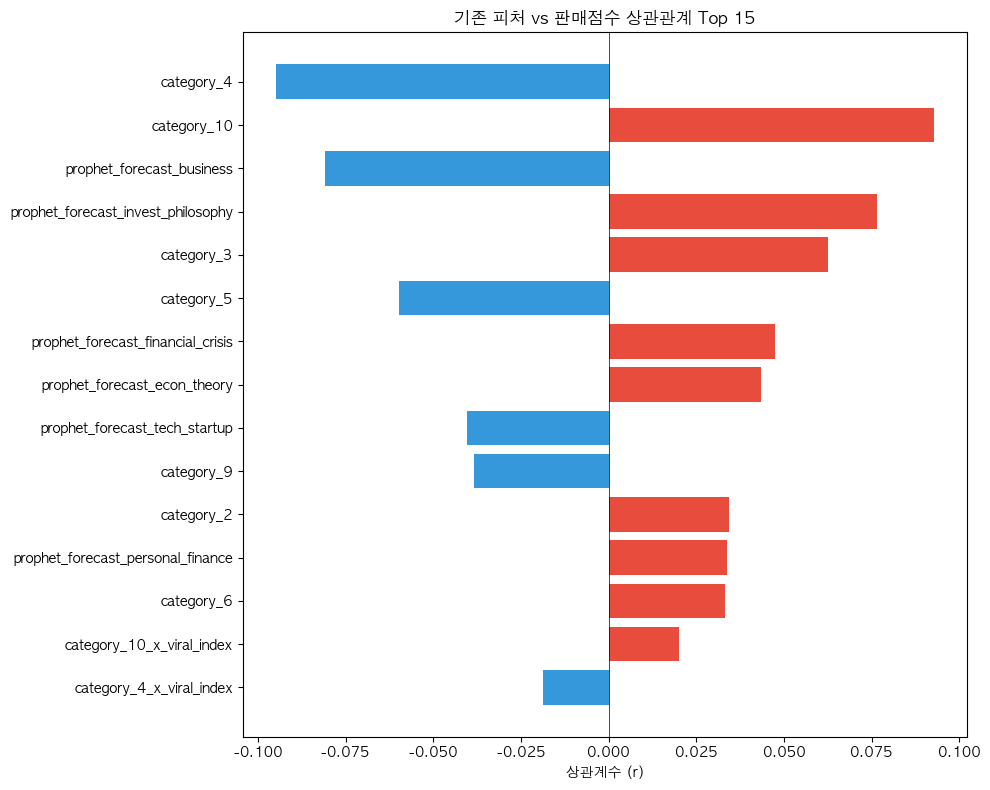

In [6]:
# 상관관계 시각화 (Top 15)
fig, ax = plt.subplots(figsize=(10, 8))
top15 = corr_df.head(15)
colors = ['#e74c3c' if c > 0 else '#3498db' for c in top15['corr']]
ax.barh(range(len(top15)), top15['corr'], color=colors)
ax.set_yticks(range(len(top15)))
ax.set_yticklabels(top15['feature'])
ax.set_xlabel('상관계수 (r)')
ax.set_title('기존 피처 vs 판매점수 상관관계 Top 15')
ax.axvline(x=0, color='black', linewidth=0.5)
ax.invert_yaxis()
plt.tight_layout()
plt.savefig(f'{IMG_PATH}/01_feature_correlation.png', dpi=150, bbox_inches='tight')
plt.show()

## 4. 기존 피처만으로 모델 학습

In [7]:
# 회귀 모델 정의
reg_models = {
    'Linear Regression': LinearRegression(),
    'Ridge': Ridge(alpha=1.0),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
    'LightGBM': lgb.LGBMRegressor(n_estimators=100, random_state=42, verbose=-1),
    'XGBoost': xgb.XGBRegressor(n_estimators=100, random_state=42, verbosity=0),
}

needs_scaling = ['Linear Regression', 'Ridge']

# 스케일링
scaler = RobustScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns, index=X_test.index)

# 기존 피처만으로 학습
base_results = []

print('[기존 피처만 사용 - 회귀 모델 성능]')
print('='*50)
print(f'{"모델":<25}{"R²":<12}{"MAE":<12}')
print('-'*50)

for model_name, model in reg_models.items():
    if model_name in needs_scaling:
        X_tr, X_te = X_train_scaled, X_test_scaled
    else:
        X_tr, X_te = X_train, X_test
    
    reg = model.__class__(**model.get_params())
    reg.fit(X_tr, y_train)
    y_pred = np.maximum(reg.predict(X_te), 0)
    
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    
    base_results.append({'model': model_name, 'r2': r2, 'mae': mae})
    print(f'{model_name:<25}{r2:<12.4f}{mae:<12.4f}')

base_results_df = pd.DataFrame(base_results)

[기존 피처만 사용 - 회귀 모델 성능]
모델                       R²          MAE         
--------------------------------------------------
Linear Regression        -0.0271     2.5105      
Ridge                    -0.0270     2.5055      
Random Forest            0.1684      2.2951      
Gradient Boosting        0.0032      2.6409      
LightGBM                 0.2089      2.0478      
XGBoost                  0.0351      2.3816      


In [8]:
# 분류 모델
clf_models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42, n_jobs=-1),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
    'LightGBM': lgb.LGBMClassifier(n_estimators=100, class_weight='balanced', random_state=42, verbose=-1),
    'XGBoost': xgb.XGBClassifier(n_estimators=100, scale_pos_weight=3, random_state=42, verbosity=0),
}

base_clf_results = []

print('\n[기존 피처만 사용 - 분류 모델 성능]')
print('='*60)
print(f'{"모델":<25}{"F1":<12}{"AUC":<12}{"Precision":<12}')
print('-'*60)

for model_name, model in clf_models.items():
    if model_name == 'Logistic Regression':
        X_tr, X_te = X_train_scaled, X_test_scaled
    else:
        X_tr, X_te = X_train, X_test
    
    clf = model.__class__(**model.get_params())
    clf.fit(X_tr, y_train_class)
    y_pred_c = clf.predict(X_te)
    y_prob = clf.predict_proba(X_te)[:, 1]
    
    f1 = f1_score(y_test_class, y_pred_c)
    auc = roc_auc_score(y_test_class, y_prob)
    prec = (y_pred_c[y_test_class == 1] == 1).mean() if y_pred_c.sum() > 0 else 0
    
    base_clf_results.append({'model': model_name, 'f1': f1, 'auc': auc})
    print(f'{model_name:<25}{f1:<12.4f}{auc:<12.4f}{prec:<12.4f}')

base_clf_results_df = pd.DataFrame(base_clf_results)


[기존 피처만 사용 - 분류 모델 성능]
모델                       F1          AUC         Precision   
------------------------------------------------------------
Logistic Regression      0.3470      0.5825      0.7032      
Random Forest            0.2936      0.6487      0.1873      
Gradient Boosting        0.2012      0.5648      0.1166      
LightGBM                 0.3571      0.5832      0.3534      
XGBoost                  0.3910      0.6553      0.3993      


## 5. 기존 피처 SHAP 분석

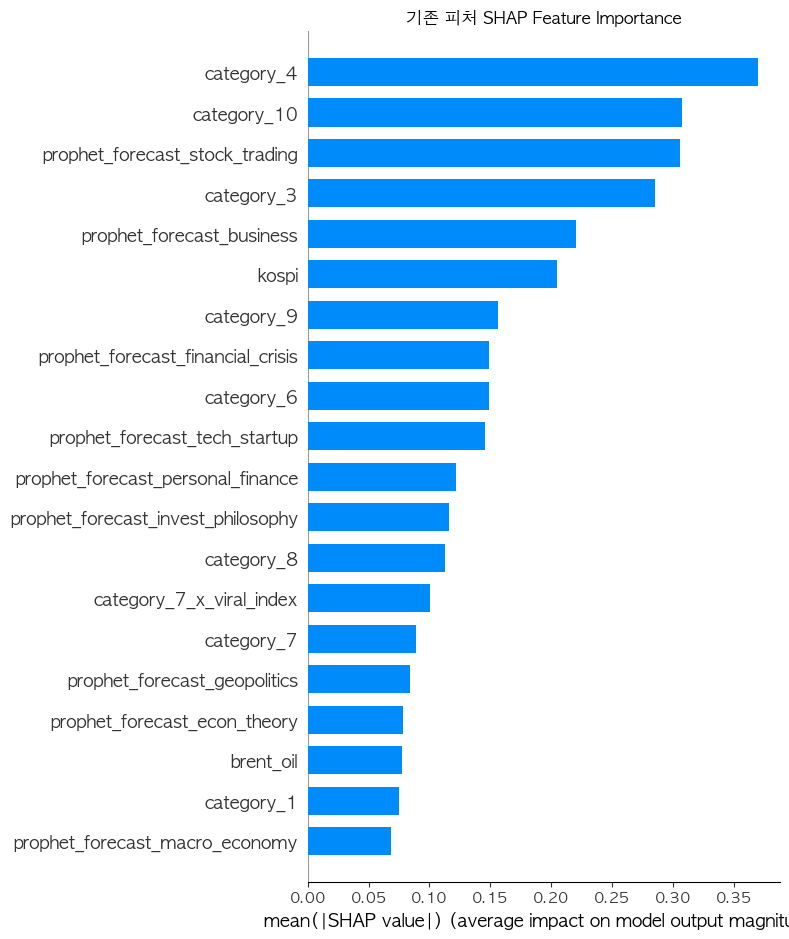

In [9]:
# LightGBM으로 SHAP 분석
reg_base = lgb.LGBMRegressor(n_estimators=100, random_state=42, verbose=-1)
reg_base.fit(X_train, y_train)

explainer_base = shap.TreeExplainer(reg_base)
shap_values_base = explainer_base.shap_values(X_test)

# SHAP Summary Plot
plt.figure(figsize=(12, 10))
shap.summary_plot(shap_values_base, X_test, plot_type="bar", show=False, max_display=20)
plt.title('기존 피처 SHAP Feature Importance')
plt.tight_layout()
plt.savefig(f'{IMG_PATH}/02_base_shap_importance.png', dpi=150, bbox_inches='tight')
plt.show()

In [10]:
# SHAP 중요도 테이블
shap_base_importance = pd.DataFrame({
    'feature': feature_cols,
    'mean_abs_shap': np.abs(shap_values_base).mean(axis=0)
}).sort_values('mean_abs_shap', ascending=False)

print('[기존 피처 SHAP 중요도 Top 15]')
print('='*55)
total_imp = shap_base_importance['mean_abs_shap'].sum()
for i, (_, row) in enumerate(shap_base_importance.head(15).iterrows()):
    pct = row['mean_abs_shap'] / total_imp * 100
    cum_pct = shap_base_importance.head(i+1)['mean_abs_shap'].sum() / total_imp * 100
    print(f'{i+1:>2}. {row["feature"]:<35} {row["mean_abs_shap"]:.4f} ({pct:>5.1f}%) [누적: {cum_pct:>5.1f}%]')

[기존 피처 SHAP 중요도 Top 15]
 1. category_4                          0.3697 (  9.3%) [누적:   9.3%]
 2. category_10                         0.3077 (  7.7%) [누적:  17.0%]
 3. prophet_forecast_stock_trading      0.3062 (  7.7%) [누적:  24.7%]
 4. category_3                          0.2857 (  7.2%) [누적:  31.9%]
 5. prophet_forecast_business           0.2202 (  5.5%) [누적:  37.4%]
 6. kospi                               0.2050 (  5.2%) [누적:  42.6%]
 7. category_9                          0.1561 (  3.9%) [누적:  46.5%]
 8. prophet_forecast_financial_crisis   0.1490 (  3.7%) [누적:  50.3%]
 9. category_6                          0.1486 (  3.7%) [누적:  54.0%]
10. prophet_forecast_tech_startup       0.1459 (  3.7%) [누적:  57.7%]
11. prophet_forecast_personal_finance   0.1215 (  3.1%) [누적:  60.7%]
12. prophet_forecast_invest_philosophy  0.1159 (  2.9%) [누적:  63.6%]
13. category_8                          0.1125 (  2.8%) [누적:  66.5%]
14. category_7_x_viral_index            0.1004 (  2.5%) [누적:  69.0%]
15. catego

## 6. Feature Selection

### 방법론
1. **다중공선성 제거**: 피처 간 상관관계 > 0.8인 경우 SHAP 중요도 낮은 피처 제거
2. **SHAP 기반 선택**: 누적 중요도 80% 달성하는 Top N 피처 선택
3. **성능 비교**: 전체 피처 vs 선택된 피처

In [11]:
# Step 1: 다중공선성 분석 (피처 간 상관관계)
corr_matrix = X_train[feature_cols].corr().abs()

# 상관관계 > 0.8인 피처 쌍 찾기
high_corr_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        if corr_matrix.iloc[i, j] > 0.8:
            feat1 = corr_matrix.columns[i]
            feat2 = corr_matrix.columns[j]
            high_corr_pairs.append((feat1, feat2, corr_matrix.iloc[i, j]))

print('[다중공선성 분석: 상관계수 > 0.8인 피처 쌍]')
print('='*70)
if high_corr_pairs:
    for feat1, feat2, corr in sorted(high_corr_pairs, key=lambda x: -x[2]):
        # SHAP 중요도 비교
        imp1 = shap_base_importance[shap_base_importance['feature'] == feat1]['mean_abs_shap'].values[0]
        imp2 = shap_base_importance[shap_base_importance['feature'] == feat2]['mean_abs_shap'].values[0]
        remove = feat2 if imp1 > imp2 else feat1
        print(f'  {feat1:<30} vs {feat2:<30} (r={corr:.3f}) → 제거: {remove}')
else:
    print('  상관계수 > 0.8인 피처 쌍 없음')

# 제거할 피처 목록
features_to_remove = set()
for feat1, feat2, corr in high_corr_pairs:
    imp1 = shap_base_importance[shap_base_importance['feature'] == feat1]['mean_abs_shap'].values[0]
    imp2 = shap_base_importance[shap_base_importance['feature'] == feat2]['mean_abs_shap'].values[0]
    features_to_remove.add(feat2 if imp1 > imp2 else feat1)

print(f'\n다중공선성으로 제거할 피처: {len(features_to_remove)}개')
if features_to_remove:
    print(f'  {list(features_to_remove)}')

[다중공선성 분석: 상관계수 > 0.8인 피처 쌍]
  category_7                     vs prophet_forecast_stock_trading (r=0.979) → 제거: category_7
  category_6                     vs prophet_forecast_personal_finance (r=0.968) → 제거: prophet_forecast_personal_finance
  category_9                     vs prophet_forecast_tech_startup  (r=0.965) → 제거: prophet_forecast_tech_startup
  category_1                     vs prophet_forecast_macro_economy (r=0.935) → 제거: prophet_forecast_macro_economy
  category_2                     vs prophet_forecast_econ_theory   (r=0.931) → 제거: category_2
  category_4                     vs prophet_forecast_business      (r=0.906) → 제거: prophet_forecast_business
  category_10                    vs prophet_forecast_invest_philosophy (r=0.819) → 제거: prophet_forecast_invest_philosophy

다중공선성으로 제거할 피처: 7개
  ['prophet_forecast_invest_philosophy', 'prophet_forecast_macro_economy', 'prophet_forecast_personal_finance', 'category_2', 'prophet_forecast_tech_startup', 'prophet_forecast_business

In [12]:
# Step 2: SHAP 기반 피처 선택 (누적 중요도 80%)
# 다중공선성 제거 후 남은 피처에서 선택
remaining_features = [f for f in feature_cols if f not in features_to_remove]
shap_remaining = shap_base_importance[shap_base_importance['feature'].isin(remaining_features)].copy()
shap_remaining = shap_remaining.sort_values('mean_abs_shap', ascending=False).reset_index(drop=True)

# 누적 중요도 계산
total_remaining_imp = shap_remaining['mean_abs_shap'].sum()
shap_remaining['cum_importance'] = shap_remaining['mean_abs_shap'].cumsum() / total_remaining_imp

# 누적 80% 달성하는 피처 수
n_features_80 = (shap_remaining['cum_importance'] <= 0.80).sum() + 1
selected_features_80 = shap_remaining.head(n_features_80)['feature'].tolist()

# 여러 threshold 테스트
thresholds = [0.60, 0.70, 0.80, 0.90]
selected_by_threshold = {}
for thresh in thresholds:
    n = (shap_remaining['cum_importance'] <= thresh).sum() + 1
    selected_by_threshold[thresh] = shap_remaining.head(n)['feature'].tolist()

print('[SHAP 기반 피처 선택]')
print('='*60)
print(f'다중공선성 제거 후 피처 수: {len(remaining_features)}개')
print(f'\n[누적 중요도별 선택 피처 수]')
for thresh, feats in selected_by_threshold.items():
    print(f'  {int(thresh*100)}% 누적: {len(feats)}개 피처')

print(f'\n[80% 누적 중요도 선택 피처 ({len(selected_features_80)}개)]')
for i, feat in enumerate(selected_features_80):
    imp = shap_remaining[shap_remaining['feature'] == feat]['mean_abs_shap'].values[0]
    cum = shap_remaining[shap_remaining['feature'] == feat]['cum_importance'].values[0]
    print(f'  {i+1:>2}. {feat:<35} (누적: {cum*100:.1f}%)')

[SHAP 기반 피처 선택]
다중공선성 제거 후 피처 수: 36개

[누적 중요도별 선택 피처 수]
  60% 누적: 8개 피처
  70% 누적: 12개 피처
  80% 누적: 16개 피처
  90% 누적: 23개 피처

[80% 누적 중요도 선택 피처 (16개)]
   1. category_4                          (누적: 11.6%)
   2. category_10                         (누적: 21.3%)
   3. prophet_forecast_stock_trading      (누적: 30.9%)
   4. category_3                          (누적: 39.9%)
   5. kospi                               (누적: 46.3%)
   6. category_9                          (누적: 51.2%)
   7. prophet_forecast_financial_crisis   (누적: 55.9%)
   8. category_6                          (누적: 60.6%)
   9. category_8                          (누적: 64.1%)
  10. category_7_x_viral_index            (누적: 67.2%)
  11. prophet_forecast_geopolitics        (누적: 69.9%)
  12. prophet_forecast_econ_theory        (누적: 72.3%)
  13. brent_oil                           (누적: 74.8%)
  14. category_1                          (누적: 77.1%)
  15. usd_krw                             (누적: 79.0%)
  16. category_9_x_viral_index           

In [13]:
# Step 3: 피처 선택 전후 성능 비교
print('[Feature Selection 성능 비교]')
print('='*75)

# 테스트할 피처셋
feature_sets_test = {
    '전체 (43개)': feature_cols,
    '다중공선성 제거': remaining_features,
    'SHAP 80%': selected_features_80,
    'SHAP 70%': selected_by_threshold[0.70],
    'SHAP 60%': selected_by_threshold[0.60],
}

selection_results = []

for set_name, feat_list in feature_sets_test.items():
    # 스케일링
    scaler_sel = RobustScaler()
    X_tr_sel = pd.DataFrame(scaler_sel.fit_transform(X_train[feat_list]), columns=feat_list)
    X_te_sel = pd.DataFrame(scaler_sel.transform(X_test[feat_list]), columns=feat_list)
    
    # LightGBM 회귀
    reg_sel = lgb.LGBMRegressor(n_estimators=100, random_state=42, verbose=-1)
    reg_sel.fit(X_train[feat_list], y_train)
    y_pred_sel = np.maximum(reg_sel.predict(X_test[feat_list]), 0)
    r2_sel = r2_score(y_test, y_pred_sel)
    mae_sel = mean_absolute_error(y_test, y_pred_sel)
    
    # LightGBM 분류
    clf_sel = lgb.LGBMClassifier(n_estimators=100, class_weight='balanced', random_state=42, verbose=-1)
    clf_sel.fit(X_train[feat_list], y_train_class)
    y_prob_sel = clf_sel.predict_proba(X_test[feat_list])[:, 1]
    y_pred_c_sel = clf_sel.predict(X_test[feat_list])
    f1_sel = f1_score(y_test_class, y_pred_c_sel)
    auc_sel = roc_auc_score(y_test_class, y_prob_sel)
    
    selection_results.append({
        'feature_set': set_name,
        'n_features': len(feat_list),
        'r2': r2_sel,
        'mae': mae_sel,
        'f1': f1_sel,
        'auc': auc_sel
    })

selection_df = pd.DataFrame(selection_results)

print(f'{"피처셋":<20}{"피처수":<10}{"R²":<12}{"MAE":<12}{"F1":<12}{"AUC":<12}')
print('-'*75)
for _, row in selection_df.iterrows():
    print(f'{row["feature_set"]:<20}{row["n_features"]:<10}{row["r2"]:<12.4f}{row["mae"]:<12.4f}{row["f1"]:<12.4f}{row["auc"]:<12.4f}')

# 최적 피처셋 선택
best_by_r2 = selection_df.loc[selection_df['r2'].idxmax()]
best_by_f1 = selection_df.loc[selection_df['f1'].idxmax()]
print(f'\n[최적 피처셋]')
print(f'  회귀 (R² 기준): {best_by_r2["feature_set"]} ({best_by_r2["n_features"]}개) - R²={best_by_r2["r2"]:.4f}')
print(f'  분류 (F1 기준): {best_by_f1["feature_set"]} ({best_by_f1["n_features"]}개) - F1={best_by_f1["f1"]:.4f}')

[Feature Selection 성능 비교]
피처셋                 피처수       R²          MAE         F1          AUC         
---------------------------------------------------------------------------
전체 (43개)            43        0.2089      2.0478      0.3571      0.5832      
다중공선성 제거            36        0.2756      1.8834      0.3245      0.5648      
SHAP 80%            16        0.3266      1.9001      0.3810      0.6188      
SHAP 70%            12        0.3302      1.8179      0.4476      0.6378      
SHAP 60%            8         0.4070      1.6349      0.4877      0.6884      

[최적 피처셋]
  회귀 (R² 기준): SHAP 60% (8개) - R²=0.4070
  분류 (F1 기준): SHAP 60% (8개) - F1=0.4877


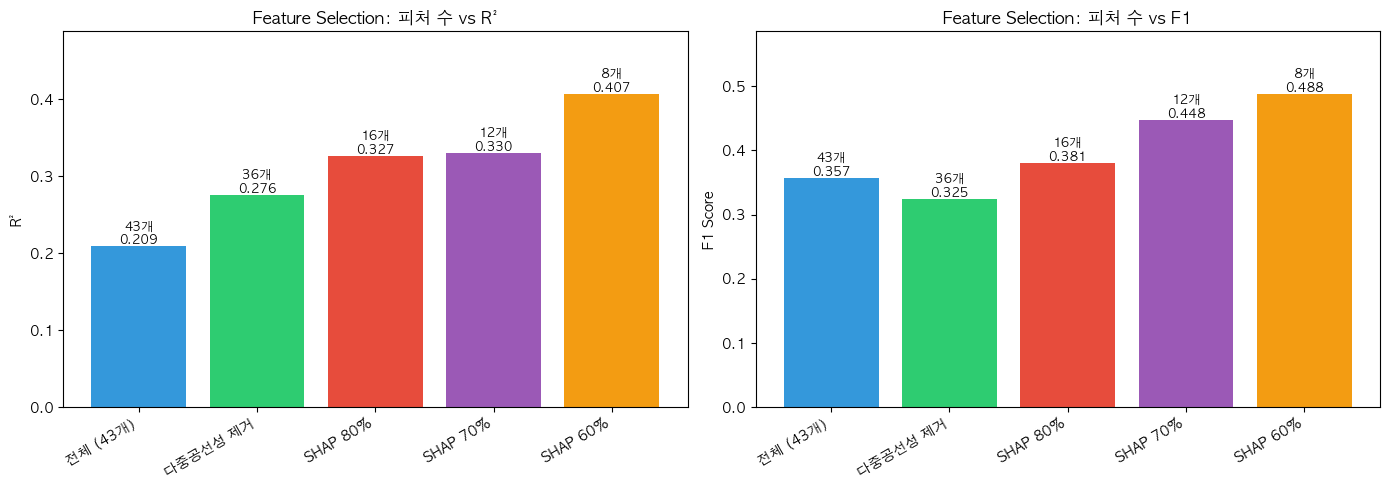


→ 이후 분석에 사용할 피처셋: SHAP 80% (16개)


In [14]:
# Feature Selection 결과 시각화
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 피처 수 vs R²
ax1 = axes[0]
ax1.bar(selection_df['feature_set'], selection_df['r2'], color=['#3498db', '#2ecc71', '#e74c3c', '#9b59b6', '#f39c12'])
ax1.set_ylabel('R²')
ax1.set_title('Feature Selection: 피처 수 vs R²')
ax1.set_xticklabels(selection_df['feature_set'], rotation=30, ha='right')
for i, (_, row) in enumerate(selection_df.iterrows()):
    ax1.annotate(f'{row["n_features"]}개\n{row["r2"]:.3f}', 
                 xy=(i, row['r2']), ha='center', va='bottom', fontsize=9)
ax1.set_ylim(0, max(selection_df['r2']) * 1.2)

# 피처 수 vs F1
ax2 = axes[1]
ax2.bar(selection_df['feature_set'], selection_df['f1'], color=['#3498db', '#2ecc71', '#e74c3c', '#9b59b6', '#f39c12'])
ax2.set_ylabel('F1 Score')
ax2.set_title('Feature Selection: 피처 수 vs F1')
ax2.set_xticklabels(selection_df['feature_set'], rotation=30, ha='right')
for i, (_, row) in enumerate(selection_df.iterrows()):
    ax2.annotate(f'{row["n_features"]}개\n{row["f1"]:.3f}', 
                 xy=(i, row['f1']), ha='center', va='bottom', fontsize=9)
ax2.set_ylim(0, max(selection_df['f1']) * 1.2)

plt.tight_layout()
plt.savefig(f'{IMG_PATH}/04_feature_selection_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

# 선택된 피처셋을 이후 분석에 사용
selected_features = selected_features_80  # 80% 누적 중요도 기준
print(f'\n→ 이후 분석에 사용할 피처셋: SHAP 80% ({len(selected_features)}개)')

## 6. 기존 피처 예측 결과 시각화

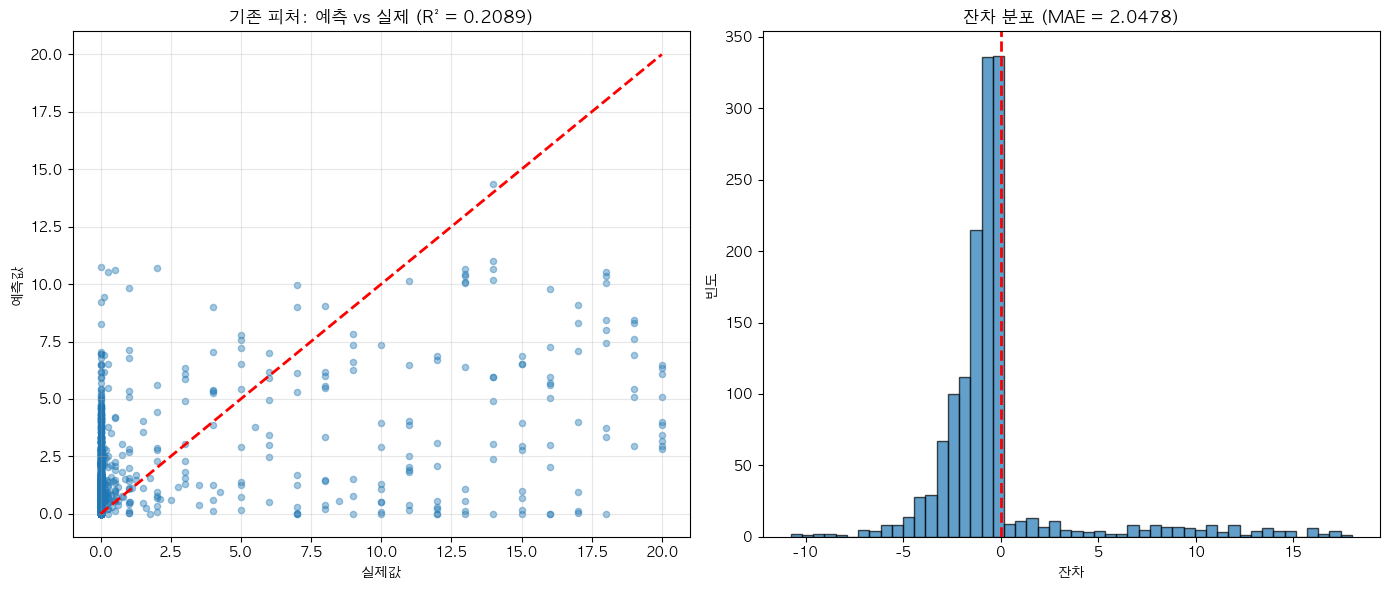

In [15]:
# 예측 vs 실제
y_pred_base = np.maximum(reg_base.predict(X_test), 0)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# 산점도
ax1 = axes[0]
ax1.scatter(y_test, y_pred_base, alpha=0.4, s=20)
ax1.plot([0, y_test.max()], [0, y_test.max()], 'r--', lw=2)
ax1.set_xlabel('실제값')
ax1.set_ylabel('예측값')
ax1.set_title(f'기존 피처: 예측 vs 실제 (R² = {r2_score(y_test, y_pred_base):.4f})')
ax1.grid(True, alpha=0.3)

# 잔차 분포
ax2 = axes[1]
residuals = y_test - y_pred_base
ax2.hist(residuals, bins=50, edgecolor='black', alpha=0.7)
ax2.axvline(x=0, color='r', linestyle='--', lw=2)
ax2.set_xlabel('잔차')
ax2.set_ylabel('빈도')
ax2.set_title(f'잔차 분포 (MAE = {mean_absolute_error(y_test, y_pred_base):.4f})')

plt.tight_layout()
plt.savefig(f'{IMG_PATH}/03_base_prediction_result.png', dpi=150, bbox_inches='tight')
plt.show()

---
# Part 2: Lag 피처 (전주 판매점수) 추가

**y_lag1 (전주 판매점수)**를 추가했을 때 예측 성능이 어떻게 변하는가?

## 7. Lag 피처 생성

In [16]:
# Lag 피처 생성
df_lag = df.copy()
for lag in [1, 2, 3, 4]:
    df_lag[f'y_lag{lag}'] = df_lag.groupby('product_code')['y_sales_score'].shift(lag)

print('[Lag 피처 결측치]')
for lag in [1, 2, 3, 4]:
    na = df_lag[f'y_lag{lag}'].isna().sum()
    print(f'  y_lag{lag}: {na}개 ({na/len(df_lag)*100:.1f}%)')

# 결측치 제거
df_lag = df_lag.dropna(subset=['y_lag1']).reset_index(drop=True)
print(f'\n결측치 제거 후: {len(df_lag):,}개')

[Lag 피처 결측치]
  y_lag1: 141개 (2.0%)
  y_lag2: 282개 (3.9%)
  y_lag3: 423개 (5.9%)
  y_lag4: 564개 (7.8%)

결측치 제거 후: 7,050개


In [17]:
# Lag 피처 상관관계
y_lag_full = df_lag['y_sales_score']

print('[Lag 피처 vs 타겟 상관관계]')
print('='*40)
for lag in [1, 2, 3, 4]:
    corr, pval = stats.pearsonr(df_lag[f'y_lag{lag}'].dropna(), df_lag.loc[df_lag[f'y_lag{lag}'].notna(), 'y_sales_score'])
    print(f'  y_lag{lag}: r = {corr:.4f} (p < 0.001)')

# 기존 피처 최고 상관관계와 비교
best_base = corr_df.iloc[0]
lag1_corr = stats.pearsonr(df_lag['y_lag1'], df_lag['y_sales_score'])[0]
print(f'\n[비교]')
print(f'  기존 피처 최고: {best_base["feature"]} (r = {best_base["corr"]:.4f})')
print(f'  y_lag1: r = {lag1_corr:.4f} → 기존 최고 대비 {lag1_corr/abs(best_base["corr"]):.0f}배 강함')

[Lag 피처 vs 타겟 상관관계]
  y_lag1: r = 0.8873 (p < 0.001)
  y_lag2: r = 0.7790 (p < 0.001)
  y_lag3: r = 0.6711 (p < 0.001)
  y_lag4: r = 0.5648 (p < 0.001)

[비교]
  기존 피처 최고: category_4 (r = -0.0949)
  y_lag1: r = 0.8873 → 기존 최고 대비 9배 강함


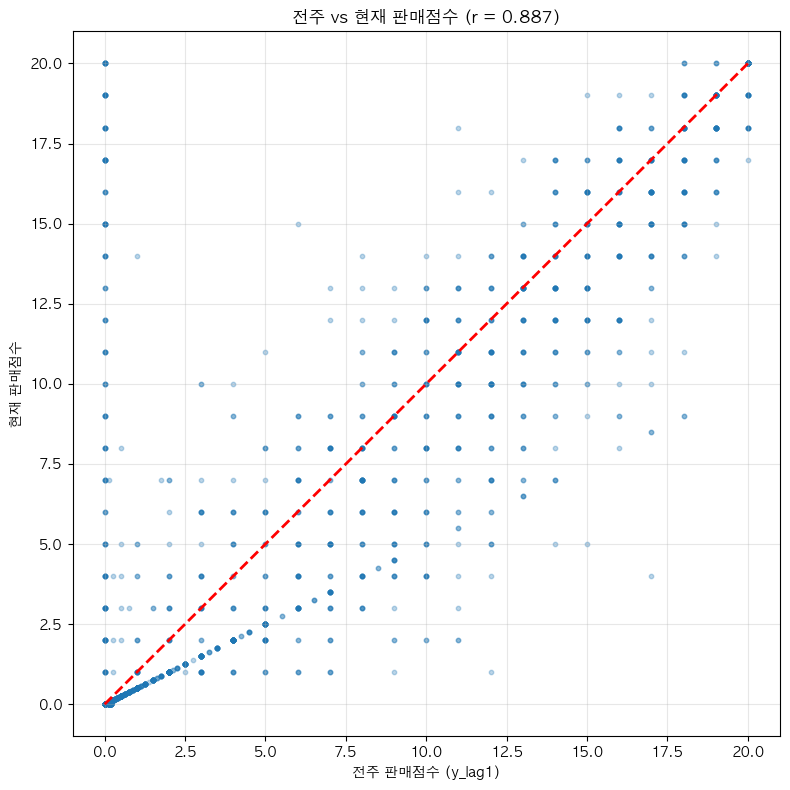

In [18]:
# y_lag1 vs y 산점도
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(df_lag['y_lag1'], df_lag['y_sales_score'], alpha=0.3, s=10)
ax.plot([0, df_lag['y_sales_score'].max()], [0, df_lag['y_sales_score'].max()], 'r--', lw=2)
ax.set_xlabel('전주 판매점수 (y_lag1)')
ax.set_ylabel('현재 판매점수')
corr_lag1 = stats.pearsonr(df_lag['y_lag1'], df_lag['y_sales_score'])[0]
ax.set_title(f'전주 vs 현재 판매점수 (r = {corr_lag1:.3f})')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(f'{IMG_PATH}/04_lag1_correlation.png', dpi=150, bbox_inches='tight')
plt.show()

## 8. Lag 피처 추가 후 모델 학습

In [19]:
# Time-based Split (Lag 데이터)
df_lag_sorted = df_lag.sort_values('ymw').reset_index(drop=True)
split_idx_lag = int(len(df_lag_sorted) * 0.8)

train_lag = df_lag_sorted.iloc[:split_idx_lag]
test_lag = df_lag_sorted.iloc[split_idx_lag:]

# Feature Selection 적용: 선택된 8개 피처 + y_lag1
selected_features_final = selected_by_threshold[0.60]  # SHAP 60% 기준 8개
feature_cols_lag_selected = selected_features_final + ['y_lag1']
feature_cols_lag_all = feature_cols + ['y_lag1']

print('[Feature Selection 적용]')
print(f'  선택된 기존 피처: {len(selected_features_final)}개')
print(f'  + y_lag1 추가: {len(feature_cols_lag_selected)}개')
print(f'  (비교용) 전체 피처 + y_lag1: {len(feature_cols_lag_all)}개')

X_train_lag_selected = train_lag[feature_cols_lag_selected]
X_test_lag_selected = test_lag[feature_cols_lag_selected]
X_train_lag_all = train_lag[feature_cols_lag_all]
X_test_lag_all = test_lag[feature_cols_lag_all]
y_train_lag = train_lag['y_sales_score']
y_test_lag = test_lag['y_sales_score']
y_train_lag_class = (y_train_lag > 0).astype(int)
y_test_lag_class = (y_test_lag > 0).astype(int)

# 스케일링
scaler_lag_sel = RobustScaler()
X_train_lag_sel_scaled = pd.DataFrame(scaler_lag_sel.fit_transform(X_train_lag_selected), 
                                       columns=X_train_lag_selected.columns, index=X_train_lag_selected.index)
X_test_lag_sel_scaled = pd.DataFrame(scaler_lag_sel.transform(X_test_lag_selected), 
                                      columns=X_test_lag_selected.columns, index=X_test_lag_selected.index)

print(f'\n[Time-based Split (Lag 데이터)]')
print(f'  Train: {len(train_lag):,}개')
print(f'  Test:  {len(test_lag):,}개')

[Feature Selection 적용]
  선택된 기존 피처: 8개
  + y_lag1 추가: 9개
  (비교용) 전체 피처 + y_lag1: 44개

[Time-based Split (Lag 데이터)]
  Train: 5,640개
  Test:  1,410개


In [20]:
# y_lag1 추가 후 회귀 모델 성능 (선택된 피처 vs 전체 피처)
lag_results_selected = []
lag_results_all = []

print('[y_lag1 추가 - 회귀 모델 성능]')
print('='*80)
print(f'{"모델":<20}{"선택 피처 R²":<15}{"전체 피처 R²":<15}{"선택 MAE":<12}{"전체 MAE":<12}')
print('-'*80)

for model_name, model in reg_models.items():
    # 선택된 피처 (9개 = 8 + y_lag1)
    if model_name in needs_scaling:
        X_tr_sel, X_te_sel = X_train_lag_sel_scaled, X_test_lag_sel_scaled
    else:
        X_tr_sel, X_te_sel = X_train_lag_selected, X_test_lag_selected
    
    reg_sel = model.__class__(**model.get_params())
    reg_sel.fit(X_tr_sel, y_train_lag)
    y_pred_sel = np.maximum(reg_sel.predict(X_te_sel), 0)
    r2_sel = r2_score(y_test_lag, y_pred_sel)
    mae_sel = mean_absolute_error(y_test_lag, y_pred_sel)
    
    # 전체 피처 (44개 = 43 + y_lag1)
    if model_name in needs_scaling:
        scaler_all = RobustScaler()
        X_tr_all = pd.DataFrame(scaler_all.fit_transform(X_train_lag_all), columns=X_train_lag_all.columns)
        X_te_all = pd.DataFrame(scaler_all.transform(X_test_lag_all), columns=X_test_lag_all.columns)
    else:
        X_tr_all, X_te_all = X_train_lag_all, X_test_lag_all
    
    reg_all = model.__class__(**model.get_params())
    reg_all.fit(X_tr_all, y_train_lag)
    y_pred_all = np.maximum(reg_all.predict(X_te_all), 0)
    r2_all = r2_score(y_test_lag, y_pred_all)
    mae_all = mean_absolute_error(y_test_lag, y_pred_all)
    
    lag_results_selected.append({'model': model_name, 'r2': r2_sel, 'mae': mae_sel})
    lag_results_all.append({'model': model_name, 'r2': r2_all, 'mae': mae_all})
    
    diff = r2_sel - r2_all
    print(f'{model_name:<20}{r2_sel:<15.4f}{r2_all:<15.4f}{mae_sel:<12.4f}{mae_all:<12.4f} ({diff:+.4f})')

lag_results_selected_df = pd.DataFrame(lag_results_selected)
lag_results_all_df = pd.DataFrame(lag_results_all)

[y_lag1 추가 - 회귀 모델 성능]
모델                  선택 피처 R²       전체 피처 R²       선택 MAE      전체 MAE      
--------------------------------------------------------------------------------
Linear Regression   0.8816         0.8807         0.5485      0.5844       (+0.0009)
Ridge               0.8815         0.8808         0.5488      0.5840       (+0.0008)
Random Forest       0.8084         0.8368         0.7515      0.7194       (-0.0284)
Gradient Boosting   0.8584         0.8669         0.6061      0.5964       (-0.0086)
LightGBM            0.8638         0.8645         0.5999      0.6500       (-0.0006)
XGBoost             0.7951         0.7711         0.7170      0.8212       (+0.0239)


In [21]:
# y_lag1 추가 후 분류 모델 성능 (선택된 피처 vs 전체 피처)
lag_clf_results_selected = []
lag_clf_results_all = []

print('\n[y_lag1 추가 - 분류 모델 성능]')
print('='*80)
print(f'{"모델":<20}{"선택 F1":<12}{"전체 F1":<12}{"선택 AUC":<12}{"전체 AUC":<12}')
print('-'*80)

for model_name, model in clf_models.items():
    # 선택된 피처
    if model_name == 'Logistic Regression':
        X_tr_sel, X_te_sel = X_train_lag_sel_scaled, X_test_lag_sel_scaled
    else:
        X_tr_sel, X_te_sel = X_train_lag_selected, X_test_lag_selected
    
    clf_sel = model.__class__(**model.get_params())
    clf_sel.fit(X_tr_sel, y_train_lag_class)
    y_pred_c_sel = clf_sel.predict(X_te_sel)
    y_prob_sel = clf_sel.predict_proba(X_te_sel)[:, 1]
    f1_sel = f1_score(y_test_lag_class, y_pred_c_sel)
    auc_sel = roc_auc_score(y_test_lag_class, y_prob_sel)
    
    # 전체 피처
    if model_name == 'Logistic Regression':
        scaler_all = RobustScaler()
        X_tr_all = pd.DataFrame(scaler_all.fit_transform(X_train_lag_all), columns=X_train_lag_all.columns)
        X_te_all = pd.DataFrame(scaler_all.transform(X_test_lag_all), columns=X_test_lag_all.columns)
    else:
        X_tr_all, X_te_all = X_train_lag_all, X_test_lag_all
    
    clf_all = model.__class__(**model.get_params())
    clf_all.fit(X_tr_all, y_train_lag_class)
    y_pred_c_all = clf_all.predict(X_te_all)
    y_prob_all = clf_all.predict_proba(X_te_all)[:, 1]
    f1_all = f1_score(y_test_lag_class, y_pred_c_all)
    auc_all = roc_auc_score(y_test_lag_class, y_prob_all)
    
    lag_clf_results_selected.append({'model': model_name, 'f1': f1_sel, 'auc': auc_sel})
    lag_clf_results_all.append({'model': model_name, 'f1': f1_all, 'auc': auc_all})
    
    diff = f1_sel - f1_all
    print(f'{model_name:<20}{f1_sel:<12.4f}{f1_all:<12.4f}{auc_sel:<12.4f}{auc_all:<12.4f} ({diff:+.4f})')

lag_clf_results_selected_df = pd.DataFrame(lag_clf_results_selected)
lag_clf_results_all_df = pd.DataFrame(lag_clf_results_all)


[y_lag1 추가 - 분류 모델 성능]
모델                  선택 F1       전체 F1       선택 AUC      전체 AUC      
--------------------------------------------------------------------------------
Logistic Regression 0.9672      0.9646      0.9689      0.9739       (+0.0025)
Random Forest       0.9743      0.9742      0.9805      0.9681       (+0.0001)
Gradient Boosting   0.9672      0.9636      0.9767      0.9789       (+0.0035)
LightGBM            0.9725      0.9725      0.9728      0.9769       (+0.0000)
XGBoost             0.9689      0.9761      0.9729      0.9724       (-0.0071)


## 9. Lag 피처 추가 후 SHAP 분석

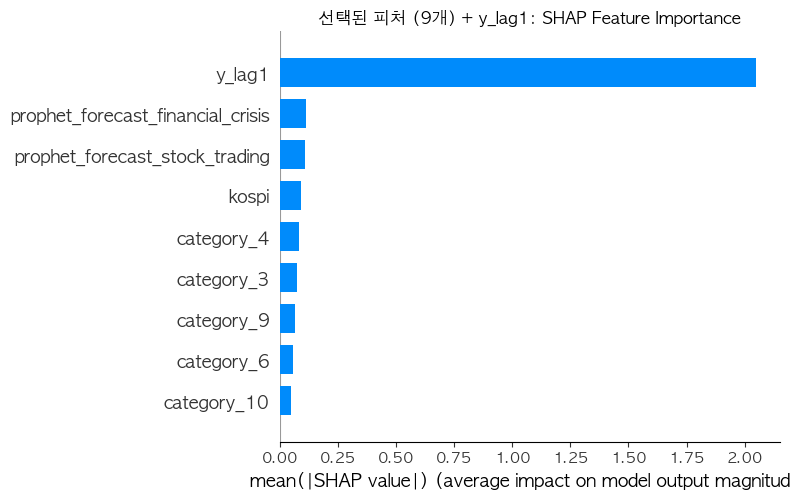

In [22]:
# LightGBM + y_lag1 SHAP 분석 (선택된 피처 사용)
reg_lag_selected = lgb.LGBMRegressor(n_estimators=100, random_state=42, verbose=-1)
reg_lag_selected.fit(X_train_lag_selected, y_train_lag)

explainer_lag = shap.TreeExplainer(reg_lag_selected)
shap_values_lag = explainer_lag.shap_values(X_test_lag_selected)

# SHAP Summary Plot
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values_lag, X_test_lag_selected, plot_type="bar", show=False, max_display=10)
plt.title(f'선택된 피처 ({len(feature_cols_lag_selected)}개) + y_lag1: SHAP Feature Importance')
plt.tight_layout()
plt.savefig(f'{IMG_PATH}/05_lag_shap_importance.png', dpi=150, bbox_inches='tight')
plt.show()# Prophet 예측값 기여도 합산
prophet_imp = shap_lag_importance[shap_lag_importance['feature'].str.contains('prophet')]['mean_abs_shap'].sum()



In [23]:
# SHAP 중요도 테이블 (선택된 피처)
shap_lag_importance = pd.DataFrame({
    'feature': feature_cols_lag_selected,
    'mean_abs_shap': np.abs(shap_values_lag).mean(axis=0)
}).sort_values('mean_abs_shap', ascending=False)

print(f'[선택된 피처 + y_lag1 SHAP 중요도 ({len(feature_cols_lag_selected)}개)]')
print('='*55)
total_imp_lag = shap_lag_importance['mean_abs_shap'].sum()
for i, (_, row) in enumerate(shap_lag_importance.iterrows()):
    pct = row['mean_abs_shap'] / total_imp_lag * 100
    print(f'{i+1:>2}. {row["feature"]:<35} {row["mean_abs_shap"]:.4f} ({pct:>5.1f}%)')

# y_lag1 vs 기타 피처 비교
y_lag1_imp = shap_lag_importance[shap_lag_importance['feature'] == 'y_lag1']['mean_abs_shap'].values[0]
other_imp = shap_lag_importance[shap_lag_importance['feature'] != 'y_lag1']['mean_abs_shap'].sum()

print(f'\n[피처 그룹별 중요도]')
print(f'  y_lag1: {y_lag1_imp/total_imp_lag*100:.1f}%')
print(f'  선택된 기존 피처 ({len(selected_features_final)}개): {other_imp/total_imp_lag*100:.1f}%')

[선택된 피처 + y_lag1 SHAP 중요도 (9개)]
 1. y_lag1                              2.0493 ( 76.2%)
 2. prophet_forecast_financial_crisis   0.1135 (  4.2%)
 3. prophet_forecast_stock_trading      0.1080 (  4.0%)
 4. kospi                               0.0908 (  3.4%)
 5. category_4                          0.0813 (  3.0%)
 6. category_3                          0.0748 (  2.8%)
 7. category_9                          0.0643 (  2.4%)
 8. category_6                          0.0565 (  2.1%)
 9. category_10                         0.0495 (  1.8%)

[피처 그룹별 중요도]
  y_lag1: 76.2%
  선택된 기존 피처 (8개): 23.8%


## 10. Lag 피처 추가 후 예측 결과 시각화

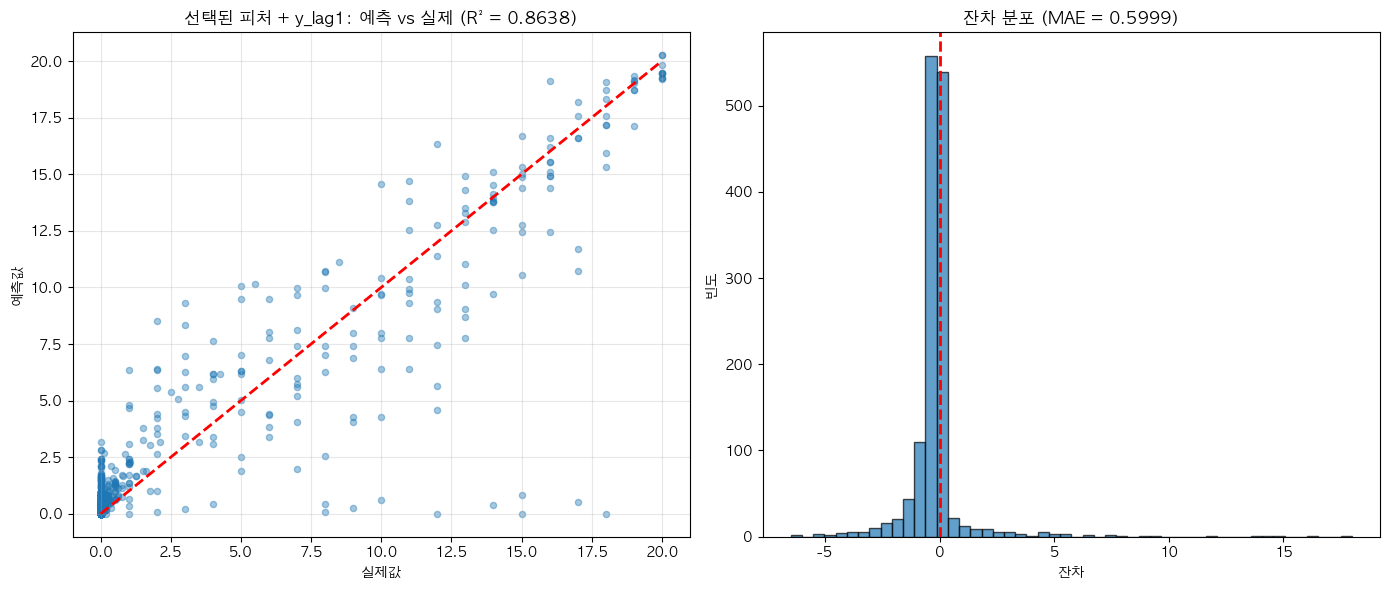

In [24]:
# 예측 vs 실제 (선택된 피처 모델)
y_pred_lag = np.maximum(reg_lag_selected.predict(X_test_lag_selected), 0)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# 산점도
ax1 = axes[0]
ax1.scatter(y_test_lag, y_pred_lag, alpha=0.4, s=20)
ax1.plot([0, y_test_lag.max()], [0, y_test_lag.max()], 'r--', lw=2)
ax1.set_xlabel('실제값')
ax1.set_ylabel('예측값')
ax1.set_title(f'선택된 피처 + y_lag1: 예측 vs 실제 (R² = {r2_score(y_test_lag, y_pred_lag):.4f})')
ax1.grid(True, alpha=0.3)

# 잔차 분포
ax2 = axes[1]
residuals_lag = y_test_lag - y_pred_lag
ax2.hist(residuals_lag, bins=50, edgecolor='black', alpha=0.7)
ax2.axvline(x=0, color='r', linestyle='--', lw=2)
ax2.set_xlabel('잔차')
ax2.set_ylabel('빈도')
ax2.set_title(f'잔차 분포 (MAE = {mean_absolute_error(y_test_lag, y_pred_lag):.4f})')

plt.tight_layout()
plt.savefig(f'{IMG_PATH}/06_lag_prediction_result.png', dpi=150, bbox_inches='tight')
plt.show()

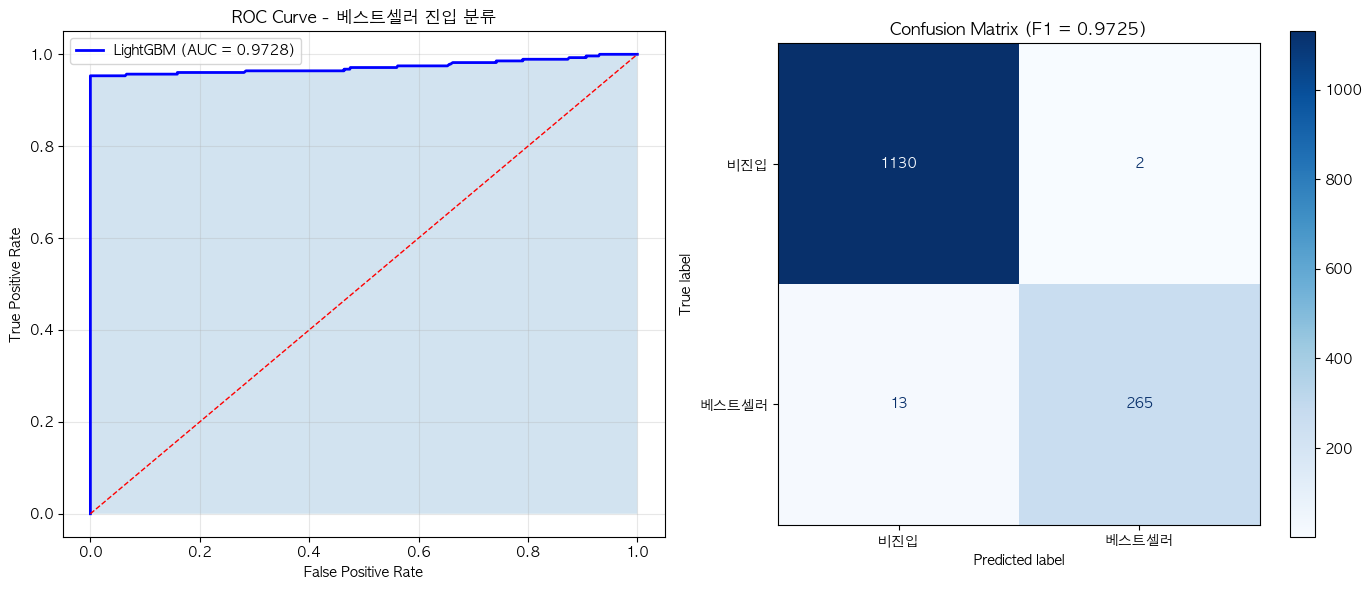

In [25]:
# ROC Curve & Confusion Matrix (선택된 피처 사용)
clf_lag = lgb.LGBMClassifier(n_estimators=100, class_weight='balanced', random_state=42, verbose=-1)
clf_lag.fit(X_train_lag_selected, y_train_lag_class)
y_prob_lag = clf_lag.predict_proba(X_test_lag_selected)[:, 1]
y_pred_lag_class = clf_lag.predict(X_test_lag_selected)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# ROC Curve
ax1 = axes[0]
fpr, tpr, _ = roc_curve(y_test_lag_class, y_prob_lag)
auc_score = roc_auc_score(y_test_lag_class, y_prob_lag)
ax1.plot(fpr, tpr, 'b-', lw=2, label=f'LightGBM (AUC = {auc_score:.4f})')
ax1.plot([0, 1], [0, 1], 'r--', lw=1)
ax1.fill_between(fpr, tpr, alpha=0.2)
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('ROC Curve - 베스트셀러 진입 분류')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Confusion Matrix
ax2 = axes[1]
cm = confusion_matrix(y_test_lag_class, y_pred_lag_class)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['비진입', '베스트셀러'])
disp.plot(ax=ax2, cmap='Blues', values_format='d')
ax2.set_title(f'Confusion Matrix (F1 = {f1_score(y_test_lag_class, y_pred_lag_class):.4f})')

plt.tight_layout()
plt.savefig(f'{IMG_PATH}/07_lag_roc_confusion.png', dpi=150, bbox_inches='tight')
plt.show()

---
# Part 3: 성능 비교 및 인사이트

## 11. 기존 피처 vs y_lag1 추가 비교

In [26]:
# 11. 요약 비교: 기존 피처 vs 선택된 피처 vs Lag 추가

# Selected Features (Lag 제외) 성능 측정
selected_results = []

for model_name, model in reg_models.items():
    if model_name in needs_scaling:
        # 스케일러 재학습 (Selected 피처 전용)
        scaler = RobustScaler()
        X_tr = pd.DataFrame(scaler.fit_transform(X_train[selected_features_final]), columns=selected_features_final)
        X_te = pd.DataFrame(scaler.transform(X_test[selected_features_final]), columns=selected_features_final)
    else:
        X_tr, X_te = X_train[selected_features_final], X_test[selected_features_final]
    
    reg = model.__class__(**model.get_params())
    reg.fit(X_tr, y_train)
    y_pred = np.maximum(reg.predict(X_te), 0)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    selected_results.append({'model': model_name, 'r2': r2, 'mae': mae})

selected_results_df = pd.DataFrame(selected_results)

# 데이터 병합 (Base vs Selected vs Lag)
reg_comp = pd.merge(base_results_df, selected_results_df, on='model', suffixes=('_base', '_sel'))
reg_comp = pd.merge(reg_comp, lag_results_selected_df, on='model')
reg_comp.rename(columns={'r2': 'r2_lag', 'mae': 'mae_lag'}, inplace=True)

print('[회귀 모델 3단계 성능 비교]')
print('='*90)
print(f'{"모델":<20}{"기존 R² (43)":<15}{"선택 R² (8)":<15}{"Lag 추가 R² (8+1)":<15}{"최종 개선":<10}')
print('-'*90)
for _, row in reg_comp.iterrows():
    diff = row['r2_lag'] - row['r2_base']
    print(f"{row['model']:<20}{row['r2_base']:<15.4f}{row['r2_sel']:<15.4f}{row['r2_lag']:<15.4f}{diff:+.4f}")

print('\n* 결론: 피처 선택만으로도 성능이 일부 개선되거나 유지되며, y_lag1 추가 시 비약적으로 성능이 향상됨.')

[회귀 모델 3단계 성능 비교]
모델                  기존 R² (43)     선택 R² (8)      Lag 추가 R² (8+1)최종 개선     
------------------------------------------------------------------------------------------
Linear Regression   -0.0271        -0.0324        0.8816         +0.9086
Ridge               -0.0270        -0.0326        0.8815         +0.9085
Random Forest       0.1684         0.4128         0.8084         +0.6400
Gradient Boosting   0.0032         0.0890         0.8584         +0.8552
LightGBM            0.2089         0.4070         0.8638         +0.6549
XGBoost             0.0351         0.3942         0.7951         +0.7600

* 결론: 피처 선택만으로도 성능이 일부 개선되거나 유지되며, y_lag1 추가 시 비약적으로 성능이 향상됨.


In [27]:
# 분류 모델 3단계 성능 비교
selected_clf_results = []

for model_name, model in clf_models.items():
    if model_name == 'Logistic Regression':
        scaler = RobustScaler()
        X_tr = pd.DataFrame(scaler.fit_transform(X_train[selected_features_final]), columns=selected_features_final)
        X_te = pd.DataFrame(scaler.transform(X_test[selected_features_final]), columns=selected_features_final)
    else:
        X_tr, X_te = X_train[selected_features_final], X_test[selected_features_final]
    
    clf = model.__class__(**model.get_params())
    clf.fit(X_tr, y_train_class)
    y_pred_c = clf.predict(X_te)
    y_prob = clf.predict_proba(X_te)[:, 1]
    f1 = f1_score(y_test_class, y_pred_c)
    auc = roc_auc_score(y_test_class, y_prob)
    selected_clf_results.append({'model': model_name, 'f1': f1, 'auc': auc})

selected_clf_results_df = pd.DataFrame(selected_clf_results)

# 데이터 병합
clf_comp = pd.merge(base_clf_results_df, selected_clf_results_df, on='model', suffixes=('_base', '_sel'))
clf_comp = pd.merge(clf_comp, lag_clf_results_selected_df, on='model')
clf_comp.rename(columns={'f1': 'f1_lag', 'auc': 'auc_lag'}, inplace=True)

print('[분류 모델 3단계 성능 비교]')
print('='*90)
print(f'{"모델":<20}{"기존 F1":<15}{"선택 F1":<15}{"Lag 추가 F1":<15}{"최종 개선":<10}')
print('-'*90)
for _, row in clf_comp.iterrows():
    diff = row['f1_lag'] - row['f1_base']
    print(f"{row['model']:<20}{row['f1_base']:<15.4f}{row['f1_sel']:<15.4f}{row['f1_lag']:<15.4f}{diff:+.4f}")

[분류 모델 3단계 성능 비교]
모델                  기존 F1          선택 F1          Lag 추가 F1      최종 개선     
------------------------------------------------------------------------------------------
Logistic Regression 0.3470         0.3304         0.9672         +0.6202
Random Forest       0.2936         0.6321         0.9743         +0.6806
Gradient Boosting   0.2012         0.2191         0.9672         +0.7659
LightGBM            0.3571         0.4877         0.9725         +0.6153
XGBoost             0.3910         0.5994         0.9689         +0.5779


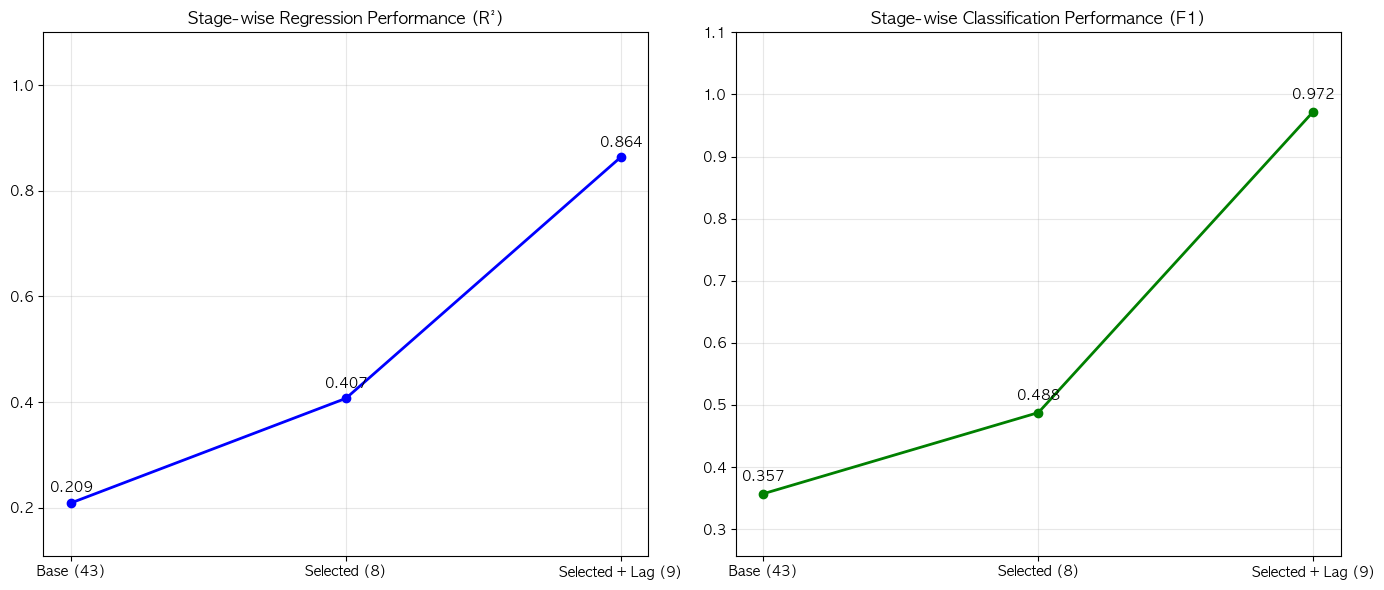

In [28]:
# 성능 변화 시각화 (R² 및 F1)
plt.figure(figsize=(14, 6))

# 1. 회귀 점수 변화 (LightGBM 기준)
plt.subplot(1, 2, 1)
lgbm_reg = reg_comp[reg_comp['model'] == 'LightGBM'].iloc[0]
stages = ['Base (43)', 'Selected (8)', 'Selected + Lag (9)']
scores = [lgbm_reg['r2_base'], lgbm_reg['r2_sel'], lgbm_reg['r2_lag']]
plt.plot(stages, scores, marker='o', linestyle='-', color='b', linewidth=2)
for i, v in enumerate(scores): 
    plt.text(i, v + 0.02, f'{v:.3f}', ha='center')
plt.title('Stage-wise Regression Performance (R²)')
plt.ylim(min(scores)-0.1, 1.1)
plt.grid(True, alpha=0.3)

# 2. 분류 점수 변화 (LightGBM 기준)
plt.subplot(1, 2, 2)
lgbm_clf = clf_comp[clf_comp['model'] == 'LightGBM'].iloc[0]
scores_f1 = [lgbm_clf['f1_base'], lgbm_clf['f1_sel'], lgbm_clf['f1_lag']]
plt.plot(stages, scores_f1, marker='o', linestyle='-', color='g', linewidth=2)
for i, v in enumerate(scores_f1): 
    plt.text(i, v + 0.02, f'{v:.3f}', ha='center')
plt.title('Stage-wise Classification Performance (F1)')
plt.ylim(min(scores_f1)-0.1, 1.1)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f'{IMG_PATH}/08_final_stage_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

## 12. 최종 결론

In [29]:
print('='*70)
print('최종 분석 결론')
print('='*70)

print('\n[1. 기존 피처만 사용 시]')
print(f'  - 회귀 R² (LightGBM): {base_results_df[base_results_df["model"]=="LightGBM"]["r2"].values[0]:.4f}')
print(f'  - 분류 F1 (LightGBM): {base_clf_results_df[base_clf_results_df["model"]=="LightGBM"]["f1"].values[0]:.4f}')
print(f'  - 해석: 바이럴 지수, Prophet 예측값으로는 예측 어려움')

print('\n[2. y_lag1 추가 시]')
print(f'  - 회귀 R² (LightGBM): {lag_results_selected_df[lag_results_selected_df["model"]=="LightGBM"]["r2"].values[0]:.4f}')
print(f'  - 분류 F1 (LightGBM): {lag_clf_results_selected_df[lag_clf_results_selected_df["model"]=="LightGBM"]["f1"].values[0]:.4f}')
    lgbm_improvement = (reg_comp[reg_comp['model']=='LightGBM']['r2_lag'].values[0] / reg_comp[reg_comp['model']=='LightGBM']['r2_base'].values[0] - 1) * 100
print(f'  - 개선율: R² +{lgbm_improvement:.0f}%')

print('\n[3. SHAP 피처 중요도]')
print(f'  - y_lag1: {y_lag1_imp/total_imp_lag*100:.1f}%')
print(f'  - prophet_forecast (10개): {prophet_imp/total_imp_lag*100:.1f}%')

print('\n[4. 핵심 인사이트]')
print('  - "과거 성과가 미래 성과를 결정한다" (베스트셀러 관성 효과)')
print('  - 바이럴 지수, Prophet 예측값은 y_lag1 대비 기여도 미미')
print('  - 전주에 베스트셀러였던 책은 이번 주에도 베스트셀러일 확률 높음')

최종 분석 결론

[1. 기존 피처만 사용 시]
  - 회귀 R² (LightGBM): 0.2089
  - 분류 F1 (LightGBM): 0.3571
  - 해석: 바이럴 지수, Prophet 예측값으로는 예측 어려움

[2. y_lag1 추가 시]


In [ ]:
# 저장된 이미지 목록
print('\n[저장된 시각화 파일]')
for f in sorted(os.listdir(IMG_PATH)):
    print(f'  {f}')


[저장된 시각화 파일]
  01_feature_correlation.png
  02_base_shap_importance.png
  03_base_prediction_result.png
  04_feature_selection_comparison.png
  04_lag1_correlation.png
  05_lag_shap_importance.png
  06_lag_prediction_result.png
  07_lag_roc_confusion.png
  08_performance_comparison.png
  lag_correlation_heatmap.png
  lightgbm_feature_importance.png
  model_performance_heatmap.png
  prediction_vs_actual.png
  roc_confusion_matrix.png
  shap_dependence_y_lag1.png
  shap_feature_importance_bar.png
  shap_summary_beeswarm.png
  three_methods_comparison.png
  v3_vs_v4_comparison.png
  y_lag1_vs_y_scatter.png
